### Problem statement:
Given the dataset consisting of driver images in car and corresponding labels for 10 nos. categories (e.g. safe driving, texting, talking etc.), your task is to build a classification model to predict the category for that image

I have joined this competetion on kaggle and used kaggle notebook with P100 GPU <br>
Data was already uploaded as input in this notebook

In [1]:
# read driver_imgs_list.csv file and 
# make a dict which has key-> classes and values-> images with respected to their class
import csv
data = {}
with open('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        key = row[1]
        if key in data:
            data[key].append(row[2])
        else:
            data[key] = [row[2]]

In [2]:
for key in data:
  # print classes and corresponding their images count
  print(key, " -> ", len(data[key]))

c0  ->  2489
c1  ->  2267
c2  ->  2317
c3  ->  2346
c4  ->  2326
c5  ->  2312
c6  ->  2325
c7  ->  2002
c8  ->  1911
c9  ->  2129


In [3]:
# Extract classes from dictionary
classes = list(data.keys())
classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

#### Create Train and validation data

In [4]:
import os

# create a master directory which have training and validation data
os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/testing')

In [5]:
dic = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

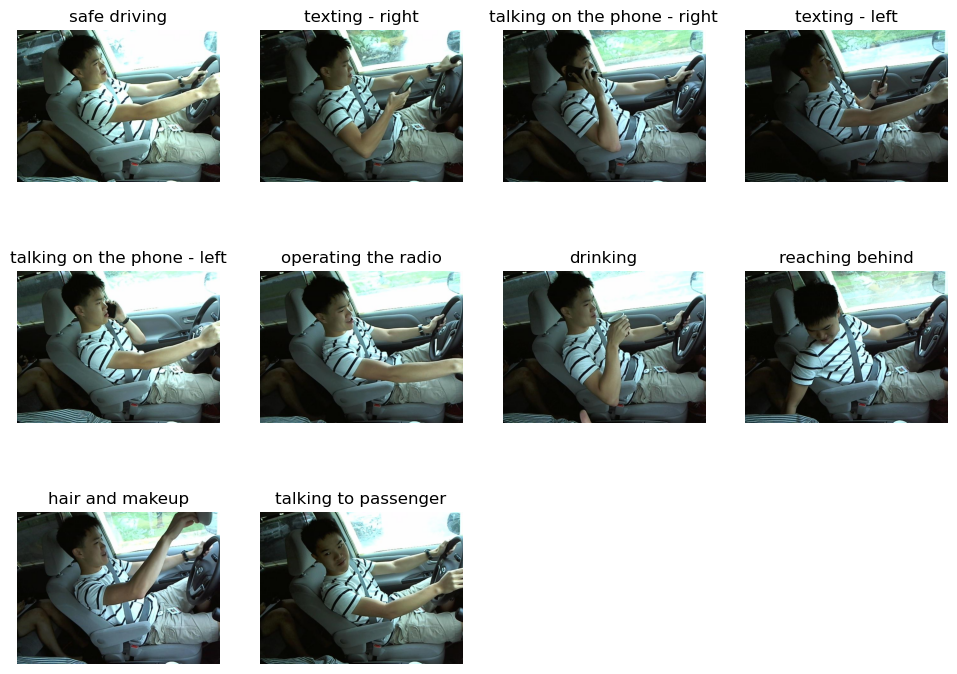

In [6]:
# Plot first image in each class
import matplotlib.pyplot as plt
from PIL import Image
fig = plt.figure(figsize = (12,12))
for i in range(10):
    image = Image.open(os.path.join("/kaggle/input/state-farm-distracted-driver-detection/imgs/train", classes[i], data[classes[i]][0]))  
    ax = fig.add_subplot(4,4,i+1)      
    ax.imshow(image)
    plt.title(dic[classes[i]])
    ax.axis('off')
plt.show()

In [7]:
# create make all classes dir in training and validation
for clss in classes:
    os.mkdir(os.path.join('master_data/training/', clss))
    os.mkdir(os.path.join('master_data/testing/', clss))

In [8]:
from shutil import copyfile
import random
split_size = 0.8

for clss, images in data.items():
    train_size = int(split_size*len(images))
    random.shuffle(images)
    train_images = images[:train_size]
    test_images = images[train_size:]
    # save images in training data
    for image in train_images:
        source = os.path.join('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/', clss, image)
        dest = os.path.join('/kaggle/working/master_data/training', clss, image)
        copyfile(source, dest)
    # save images in validation data
    for image in test_images:
        source = os.path.join('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/', clss, image)
        dest = os.path.join('/kaggle/working/master_data/testing', clss, image)
        copyfile(source, dest)

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [10]:
# create training and valiodation data from directory
train_dataset = image_dataset_from_directory(
    "/kaggle/working/master_data/training",
    image_size=(480, 640),
    batch_size=32,
    label_mode='categorical'  
)
validation_dataset = image_dataset_from_directory(
    "/kaggle/working/master_data/testing",
    image_size=(480, 640),
    batch_size=32,
    label_mode='categorical'  
)

Found 17934 files belonging to 10 classes.
Found 4490 files belonging to 10 classes.


## Create CNN Model

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [18]:
model = Sequential([Conv2D(16, (3,3), activation = 'relu', input_shape = (480, 640, 3)),
                    MaxPooling2D(2,2),
                    Conv2D(32, (3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Conv2D(32, (3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Conv2D(64, (3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Flatten(),
                    Dense(1024, activation = 'relu'),
                    Dense(512, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    Dense(10, activation = 'softmax')
                   ])

# compile the model
model.compile(optimizer= Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 478, 638, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 239, 319, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 237, 317, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 118, 158, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 116, 156, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 58, 78, 32)      

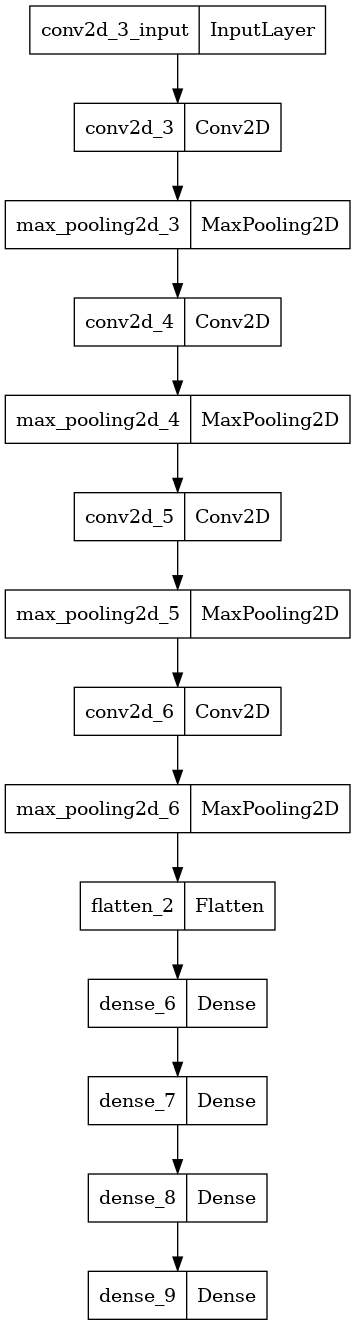

In [19]:
from keras.utils import plot_model
plot_model(model)

In [20]:
history = model.fit(train_dataset, epochs = 3, validation_data = validation_dataset)

Epoch 1/3
561/561 [==============================] - 125s 217ms/step - loss: 5.0629 - acc: 0.7857 - val_loss: 0.1137 - val_acc: 0.9657
Epoch 2/3
561/561 [==============================] - 119s 211ms/step - loss: 0.1178 - acc: 0.9692 - val_loss: 0.1542 - val_acc: 0.9646
Epoch 3/3
561/561 [==============================] - 121s 214ms/step - loss: 0.1491 - acc: 0.9653 - val_loss: 0.1254 - val_acc: 0.9759


### Plotting the Model accuracy and Losses

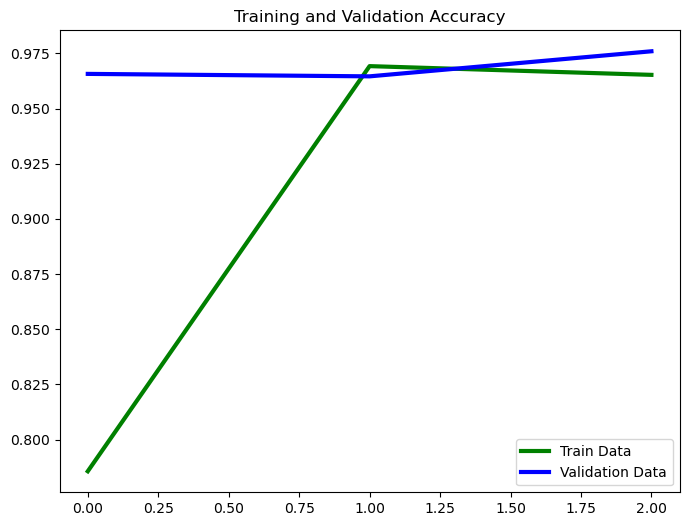

In [23]:
fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['acc'], color = 'green', label = 'Train Data', linewidth = 3)
plt.plot(history.history['val_acc'], color = 'blue', label = 'Validation Data',linewidth = 3)
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

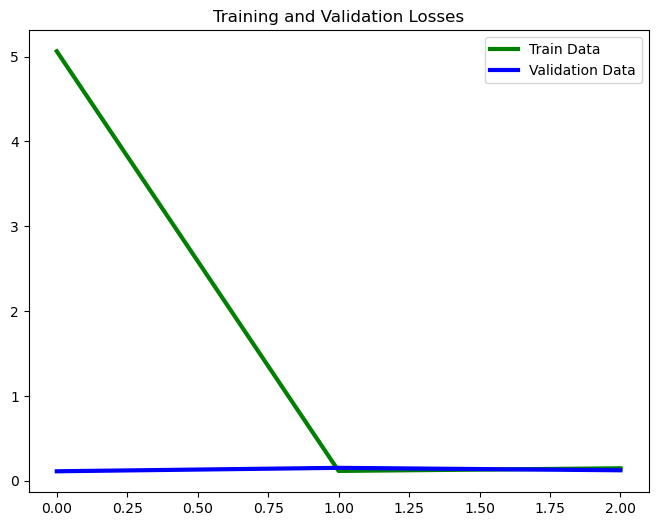

In [22]:
fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], color = 'green', label = 'Train Data',linewidth = 3)
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation Data',linewidth = 3)
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

## Use pretrained model VGG16

Due to computational limitation unable to use this pretrained model

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
base_model = VGG16(include_top = False, input_shape = (480, 640, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = "relu")(x)
output = Dense(10, activation = "softmax")(x)
model2 = Model(inputs = base_model.input, outputs = output)
model2.compile(optimizer= Adam(learning_rate = 0.0002), loss = 'categorical_crossentropy', metrics = ['acc'])
model2.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 320, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 320, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 320, 128)     147584    
                                                              

### Predict test data

In [ ]:
test_dataset = image_dataset_from_directory(
    "/kaggle/input/state-farm-distracted-driver-detection/imgs/test",
    image_size=(480, 640),
    batch_size=32,
    labels = None  
)

In [9]:
pred = model.predict(test_dataset)

2492/2492 [==============================] - 634s 254ms/step
